# Deep Networks: Building an Image Classifier - Lab

## Introduction

In this lab, we'll create a network with more than one hidden layer from scratch. The outline of this lab will be roughly the same as the previous two labs, but you'll notice that adding more hidden layers makes forward and backward propagation more complex. This is what you'll do:

- You'll start with initializing the parameters in all the layers.
- You'll implement the forward propagation module:
     - First, you'll combine a linear step and a activation function in a linear forward function.
     - Next, you'll stack the linear forward function L-1 time with a RELU activation function (for layers 1 through L-1) and then add a sigmoid layer at the end (for the final layer $L$). 
- You'll create the loss function.
- You'll implement the backward propagation module using three helper functions:
    - First, you'll create a function for the linear part of a layer's backward propagation step.
    - Next, we'll tell you how to get the gradients for the activation functions (RELU and sigmoid) and you'll implement this along with the linear part of the activation step to create a backward function.
    - Lastly, you'll stack the backward function L-1 times with the RELU activation and add the sigmoid activation in the $L$th layer in a new L_model_backward function
- You'll conclude your model by updating the parameters
- At the end of this lab, you'll combine all the helper functions in a function called `L_layer_model` and apply this model to the Santa data set you've used before!

## Objectives

You will be able to:
* Explain the architecture of a neural network
* Load and display images from file
* Batch load and process directories of images using Keras
* Code a multi-layer neural network from scratch

## Packages

First, let's import all the packages that you 'll need for this lab.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(123)

## Initialization in an L-layer Neural Network

Let's look at the initialization function you created in the previous lab. We'll try to convert this helper function to a function that can be used in a setting with $L$ layers.

Remember from the previous lab that, with one hidden layer, we initialized W and b as follows:

```python
def initialize_parameters(n_0, n_1, n_2):
    np.random.seed(123) 
    W1 = np.random.randn(n_1, n_0) * 0.05 
    b1 = np.zeros((n_1, 1))
    W2 =  np.random.randn(n_2, n_1) * 0.05 
    b2 = np.zeros((n_2, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
```

Here, n_0 was the size of the input layer, n_1 the size of the hidden layer and n_2 the size of the output layer.  

Our returned parameters represented weights (W1 and W2) and biases (b1 and b2) for these 2 layers (input to hidden and hidden to output). 

The dimensions of these parameters is an important observation which you'll work to generalize in the function below.  

* W1 has a shape of (n_1, n_0)
    * after all these weights transform our input to the hidden layer
* b1 has a shape of (n_1, 1)
    * this is a vector
* W2 has a shape of (n_2, n_1)
    * these weights compute our transformation from the hidden to output layer
* b2 has a shape of (n_2, 1)
    * again a vector of the bias for each of our final outputs

We want to generalize this function such that the parameter initialization function takes a list of arbitrary length instead of `(n_0, n_1, n_2)`, and computes as many `W`'s and `b`'s as there are layers, (hence, L of each). In this function, you'll loop over the list which is entered as an argument in `initialize_parameters_deep`. For each layer $l$, initialize $W^{[l]}$ and $b^{[l]}$.

To make it a little easier, recall from the lecture that 

$$W^{[l]}: (n^{[l]}, n^{[l-1]})$$

$$b^{[l]}: (n^{[l]}, 1)$$

In [2]:
#Your code here; 
#rceate a dictionary of parameters for W and b given a list of layer dimensions.
#Simply randomly initialize values in accordance to the shape each parameter should have.
#Use random seed 123 (as provided)
def initialize_parameters_deep(list_layer_dimensions):
    
    np.random.seed(123)
    parameters = {}
    
    #Your code here
    L = len(list_layer_dimensions)           

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(list_layer_dimensions[l], list_layer_dimensions[l-1])*0.05
        parameters['b' + str(l)] = np.zeros((list_layer_dimensions[l], 1))
        
    return parameters

## Forward propagation

### Linear forward and activation for 1 layer
Let's start building on a propagation module. As you know, in each layer of nodes $l$, two things happen

- A linear transformation $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$, where $A^{[0]} = X$. You may also find `np.dot()` useful here.
- An activation function is applied to the linear transformation. in this lab, the two activation functions are used in the neural network are:
    - *Sigmoid*: $A^{[l]} = \sigma(Z^{[l]}) = \frac{1}{ 1 + e^{-(Z^{[l]})}}$. You can          program this in python using `np.exp()`.
    - *ReLU*: The mathematical formula for ReLu is $A^{[l]} $= RELU$(Z^{[l]})$ =$ \max(0, Z^{[l]})$. You can  program this in python using `np.maximum()`.

Below, we'll define such a function. 

The output of this function will be the activation A. Additionally, we save some intermediate values for our backpropagation later on. We'll define `1inear_cache` to save the elements of the linear transformation `(A_prev, W, b)`, and `activation_cache` to save `Z`. We'll store these together in one dictionary, `cache`.

In [3]:
#Complete the templated function below as indicated by the comments
#Be sure to also carefully review the function in general in order to continue building your understanding.
def linear_activation_forward(A_prev, W, b, activation):
 
    Z = np.dot(W, A_prev) + b#Your code here; see the linear transformation above for how to compute Z
    linear_cache = (A_prev, W, b)
    activation_cache = Z
    
    #Here we define two possible activation functions
    if activation == "sigmoid":
        A = 1/(1 + np.exp(-Z)) #Your code here; use the appropriate function for a sigmoid activation function
    
    elif activation == "relu":
        A = np.maximum(0, Z) #Your code here; use the appropriate function for the ReLU activation function.
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

### Extending to  L layers

From here, we'll build a neural network with $L-1$ RELU layers and the last layer L with a SIGMOID activation function. Let's build a function that implements this using `linear_activation_forward()`.

The second argument of the function `L_model_forward` is `parameters`. Recall that this is a dictionary storing (initialized) parameters `W` and `b` for each layer of the network. We'll loop over all the values of W and b, and they are inputs of the function `linear_activation_forward`. Recall that you can use something like this to loop over `W1`, `W2`, etc.: `parameters['W'+ str(i)]` with `i` the index value.

We denote `AL` the output of the last layer (so, $\hat y$).


Make sure to keep track of the caches in the "caches" list. To add a new value `cache` to a `list`, you can use `list.append(cache)`.

In [4]:
#Once again, complete this templated function as indicated by the comments provided.
def L_model_forward(X, parameters):
    #Initialize a cache list to keep track of the caches
    caches = [] #Your code here
    A = X
    L = len(parameters) // 2 # number of layers in the neural network
    
    # Implement the RELU activation L-1 times. Add "cache" to the "caches" list.
    #Your code here
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W'+ str(l)], parameters['b' + str(l)], activation = "relu")        
        caches.append(cache)
    
    # Implement the sigmoid function for the last layer. Add "cache" to the "caches" list.
    #Your code here
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

Great! Now you have a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing your predictions. It also records all intermediate values in "caches". 

## The cost function

Just like in the last lab, the activation in the last layer provides us with the preditions on all the samples. The activations were denoted as $a^{[2] (i)}$ in the last lab (where we had one hidden layer), here they are 
$a^{[L] (i)}$, or our vectorized $A^{[L]}$ output from `L_model_forward`. The resulting cross-entropy cost, J, is essentially the same:

$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) $$



In [5]:
#Complete the templated function below, as indicated by the comments.
def compute_cost(AL, Y):
    m = Y.shape[1]

    cost = -(1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)      #No edit needed; used to make sure to get shape right (e.g. turn [[17]] into 17)
    
    return cost

## Backward propagation

Now that we've performed forward propagation, we will implement a similar procedure for backpropagation. This will allow us to calculate the gradient of our cost function with respect to our parameters. In turn, we will use these gradients to update our weights in our optimization process.

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

$$dz^{[1]}= \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} $$

$$dW^{[1]} =  \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}} }\frac{\partial z^{[1]} }{\partial W^{[1]}}$$

$$db^{[1]} =  \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}} }\frac{\partial z^{[1]} }{\partial b^{[1]}}$$

You are going to build the backward propagation in three steps:
- First we will build a `linear_backward` function
- Then we will build a linear --> activation backward function where the activation computes the derivative of either the ReLU or sigmoid activation
- Lastly, we will backpropagate through the entire model

## Linear backward


For layer $l$, you apply a linear function defined by $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ afterwards, you then apply an activation function such as the sigmoid or relu functions.

In our optimization process, we work backwards from our cost function through successive layers, computing gradients and then making small updates to parameter weights in order to reduce our cost. In each of these, we calculate gradients for the activation function (with respect to the cost function) and then repeat this process for the linear function associated with each of these layers.   

Mathematically, our algorithm has computed the gradient of the activation function, $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. Now, we want to want to get $(dW^{[l]}, db^{[l]} dA^{[l-1]})$, so that we can make updates to the weights of the linear function.


The analytical formulas for this are:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

Use these functions to complete the skeleton `linear_backward` function below. The function will take in dZ and our current cache object and should return dA (from the previous layer) as well as dW and db from the current layer.

In [6]:
#Complete the skeleton function below
def linear_backward(dZ, cache):
    A_prev, W, b = cache #Unpacking our complex object
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)#Your code here; see the formulas above
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)#Your code here; see the formulas above
    dA_prev = np.dot(W.T, dZ)#Your code here; see the formulas above
    
    return dA_prev, dW, db

##   Linear and activation backward

Now, we'll merge `linear_backward` with our activation backward to have a complete `linear_activation_backward` function. Essentially, we are now computing `dZ` which we were discussing above.

That is, $ dZ^{[l]}= dA ^{[l]} * g^{[l]'} (Z^{[l]})$. 
To calculate the derivates we have two different scenarios, depending on the activation function of choice:

- If we are using the **sigmoid activation**:

$g^{[l]'} (Z^{[l]}) = \dfrac{1}{(1+\exp(-Z))}\biggr(1- \dfrac{1}{(1+\exp(-Z))}\biggr) $

This is often easier expressed using the intermediate variable s:

$s = \dfrac{1}{(1+\exp(-Z))}$

giving us

$g^{[l]'} (Z^{[l]}) = s \bullet (1-s)$


- If we are using the **relu activation**, we simply inspect the previous activation cache. Recall that the relu is a binary decision; all values less then zero from our activation cache will be set to zero.

Below, complete the skeleton function.


In [7]:
#Complete the skeleton function below
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    Z= activation_cache
    
    if activation == "sigmoid": 
        s = 1 / (1 + np.exp(-Z))#Your code here; see the formula above
        dZ = dA * s * (1 - s)#Your code here; see the formula above
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "relu":
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.
        #Your code here; see the formula above to update your initialized dZ
        dZ[Z <= 0] = 0
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

## L-Model Backward 

Great! Now to perform our optimization, we need to cycle through our layers, starting with layer L and working backwards.


We've seen that to backpropagate, we look to compute the gradient of the activation layer, `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$. Using calculus (not covered here), we can calculate this with the formula, 

```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost wrt AL
```

You can then feed this into our `linear_activation_backward` function that we defined above to successively update the gradients stored in our cache. Remember that our last layer of the network will be the first to be updated and uses the sigmoid activation function (appropriate for our classifcation purposes). All of the previous layers, will use the relu activation function. 

With that, complete the skeleton function `L_model_backward` below in order to succesively calculate the gradients for each layer and return these as a dictionary.

In [8]:
#Complete the skeleton function below (there are 3 lines that need to be completed)
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) #Your code here; see the code snippet above
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, 'sigmoid')
                                                                #Your code here; use the helper function defined above
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # (RELU -> LINEAR) gradients
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, 'relu')#Your code here; use the helper function defined above
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

## Parameter updates

Now that we have calculated all of the gradients, you need to write a function that will perform parameter updates given the current weights, the gradients, and a learning rate. Recall that in gradient descent, this will simply be taking the current parameters and taking a step of size $\alpha$ (the learning rate) opposite the gradient:

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

Whe completing the skeleton function below, after computing the updated parameters, store them in the parameters dictionary. 

In [9]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network
    
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

##  The data 

First, let's take a look at how to load a raw image from file and display it:

(720, 687, 4)


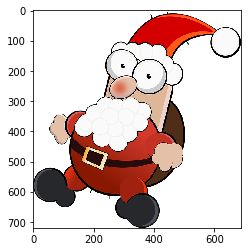

In [10]:
import matplotlib.image as mpimg
filename = 'data/validation/santa/00000448.jpg'
img=mpimg.imread(filename)
plt.imshow(img)
print(img.shape)
plt.show()

Great!  

Now let's take a look at how we can examine the gist of this code, but don't worry if you don't understand all the ins and out of the keras preprocessing method `ImageDataGenerator`. We'll explain in more detail when working with convolutional neural networks. The import piece to note here is the drastic image downgrade that we're doing here. The raw images would contain far more information but this would also be costly in time and hardware resources.

In [11]:
import time
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

Using TensorFlow backend.


In [12]:
# directory path
train_data_dir = 'data/train'
test_data_dir = 'data/validation'

# get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=132) 

# get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=790)

# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 132 images belonging to 2 classes.
Found 790 images belonging to 2 classes.


Note the drastic difference of one of these images as compared to the raw file:

(Yes; it is just an incoherent blob of dots after our tremendous compression.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


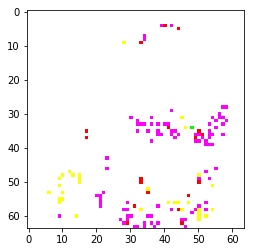

In [13]:
print(train_images[0].shape)
plt.imshow(train_images[0])

## Data Exploration and Normalization

Be sure to carefully review the three code blocks below. Here, we demonstrate some common data checks you are apt to perform after importing, followed by standard data normalization to set all values to a range between 0 and 1.

In [14]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images_orig shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training examples: 790
Number of testing examples: 132
Each image is of size: (64, 64, 3)
train_images shape: (790, 64, 64, 3)
train_labels shape: (790, 2)
test_images_orig shape: (132, 64, 64, 3)
test_labels shape: (132, 2)


In [15]:
# Reshape the training and test examples 
train_img = train_images.reshape(train_images.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_img = test_images.reshape(test_images.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_img/255.
test_x = test_img/255.

print ("train_img's shape: " + str(train_img.shape))
print ("test_img's shape: " + str(test_img.shape))


train_img's shape: (12288, 790)
test_img's shape: (12288, 132)


Output needs to be of shape $(1, X_n)$, so we perform a little manipulation by reshaping our data.

In [16]:
# Reshape the labels
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]

print ("train_labels_final's shape: " + str(train_labels_final.shape))
print ("test_labels_final's shape: " + str(test_labels_final.shape))

train_labels_final's shape: (1, 790)
test_labels_final's shape: (1, 132)


We're about to run our model, and for our example, we'll define a 4 layer model. The parameter below indicate our input size of the images, the size of our hidden layers, and finally, that we are looking for a singular class output.

In [17]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

## Putting It All Together

Now, let's finalize all of our work and put everything together to construct our deep network model. Below, initialize parameters for the model and use our helper functions defined above to perform gradient descent to optimize these weights with respect to our loss function. Afterwards, the included code will then plot the cost funciton over the number of training cycles run.

In [34]:
#Review and complete the skeleton function below.
def L_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 1000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []                         
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)#Your code here; use the previous helper functions
    
    # Create a Loop (for gradient descent)
    for i in range(num_iterations):
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)#Your code here; use the previous helper functions
        
        # Compute cost.
        cost = compute_cost(AL, Y)#Your code here; use the previous helper functions
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches) #Your code here; use the previous helper functions
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)#Your code here; use the previous helper functions
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## Call Your Function to Run the Model Training!

Use your function to calculate parameter weights using our training set outlined above.

Cost after iteration 0: 0.692950
Cost after iteration 100: 0.688229
Cost after iteration 200: 0.618626
Cost after iteration 300: 0.674327
Cost after iteration 400: 0.447688
Cost after iteration 500: 0.502493
Cost after iteration 600: 0.306287
Cost after iteration 700: 0.253660
Cost after iteration 800: 0.153690
Cost after iteration 900: 0.157524


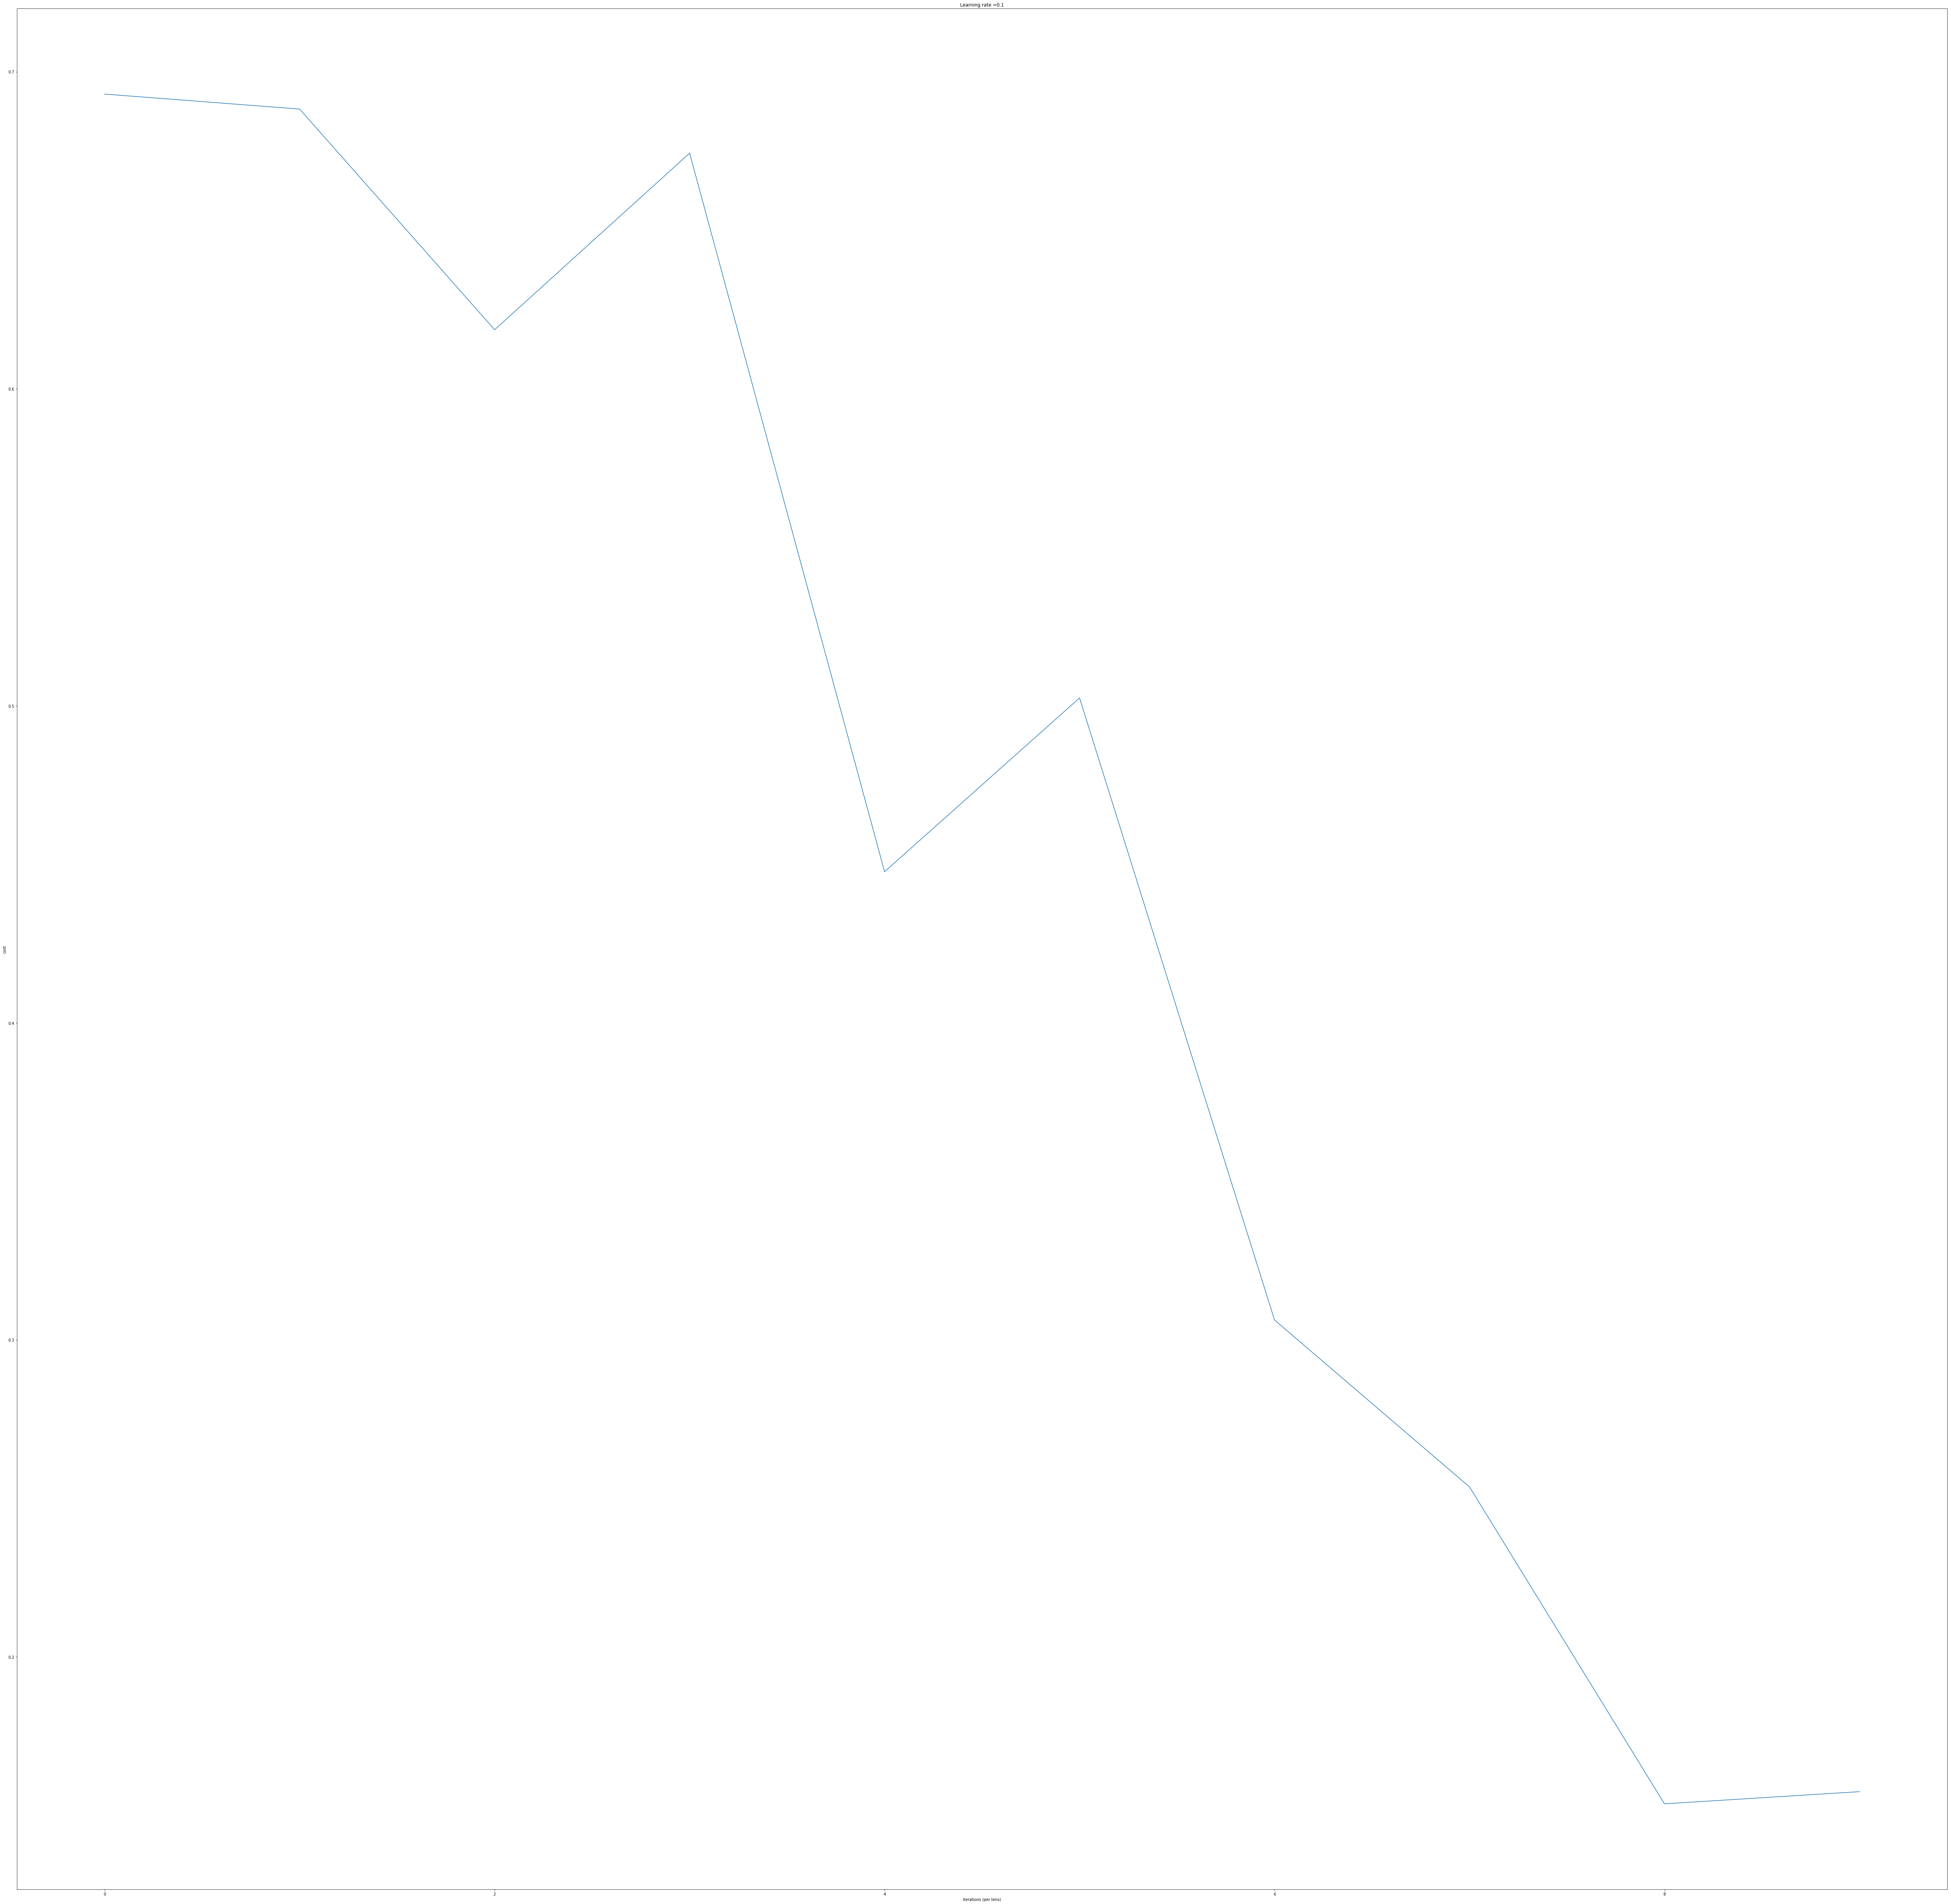

In [35]:
parameters = L_layer_model(train_x, train_labels_final, layers_dims, print_cost=True)#Your code here; use the helper function defined above

## Returning Predictions

No edits to this cell. Now that you've trained a model, the code below will take these parameters and calculate class probabilities for the input data. Optionally, if the actual class labels are provided (y) the function will also compute the accuracy of the model on this training data.

In [36]:
#No edits needed here; simply review the code below.
def predict(X, parameters, y=None):
    
    m = X.shape[1]
    n = len(parameters) // 2
    
    # Forward propagation
    probs, caches = L_model_forward(X, parameters)

    # convert probs to 0/1 predictions
    for i in range(0, probs.shape[1]):
        if probs[0,i] > 0.50:
            probs[0,i] = 1
        else:
            probs[0,i] = 0
    
    #print ("predictions: " + str(probs)); print ("true labels: " + str(y))
    if type(y) != type(None):
        print("Accuracy: "  + str(np.sum((probs == y)/m)))
        
    return probs

In [37]:
pred_train = predict(train_img, parameters, y=train_labels_final)

Accuracy: 0.640506329113924


In [38]:
pred_test = predict(test_img, parameters, y=test_labels_final) #Your code here; use the helper function defined above

Accuracy: 0.5378787878787878


## Print mislabeled images

Finally, here we demonstrate iterating through our images and printing those that are mislabbeled. Be sure to make note of the code used for displaying these images, similar to what we saw above.

In [39]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (90.0, 90.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
      #  plt.title("Prediction: " + list(classes.keys())[list(classes.values()).index(int(p[0,index]))] +
       #           " \n Class: " + list(classes.keys())[list(classes.values()).index(int(y[0,index]))])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

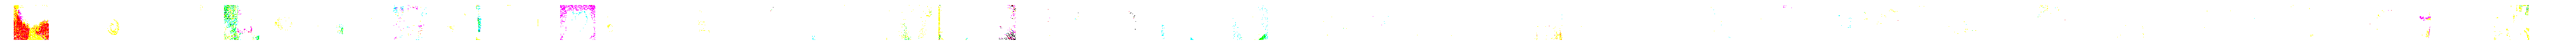

In [40]:
print_mislabeled_images(list(train_generator.class_indices), test_img, test_labels_final, pred_test)

In [41]:
classes = train_generator.class_indices


## Summary

In this lab, you once again practiced and reviewed the process of building a nueral network. This time, we built a more complex network with additional layers which drastically improves the performance on our data set with Santa images! We also made note of some important methods for importing and displaying images, a necessary preliminary step in building image recognition systems.
